In [20]:
from scipy.io import loadmat
import numpy as np

In [21]:
def calc_fairness_metric(constraint, confu_mat, num_groups=2, num_classes=2):
    if constraint == 'eopp':
        '''
        Compute EO disparity
        '''
        group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
        group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()

        pivot = (group0_tp + group1_tp) / (group0_fn + group0_tp + group1_fn + group1_tp)
        group0_tpr = group0_tp / (group0_fn + group0_tp)
        group1_tpr = group1_tp / (group1_fn + group1_tp)

        return max(abs(group0_tpr - pivot), abs(group1_tpr - pivot)) # from fairbatch paper
        #return abs(group0_tp / (group0_fn + group0_tp) - group1_tp / (group1_fn + group1_tp))

    elif constraint == 'eo':
        '''
        Compute ED disparity 
        '''

        group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
        group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()
        
        pivot_1 = (group0_tp + group1_tp) / (group0_fn + group0_tp + group1_fn + group1_tp)
        group0_tpr = group0_tp / (group0_fn + group0_tp)
        group1_tpr = group1_tp / (group1_fn + group1_tp)

        EO_Y_1 = max(abs(group0_tpr - pivot_1), abs(group1_tpr - pivot_1))

        pivot_0 = (group0_fp + group1_fp) / (group0_tn + group0_fp + group1_tn + group1_fp)
        group0_fpr = (group0_fp) / (group0_tn + group0_fp)
        group1_fpr = (group1_fp) / (group1_tn + group1_fp)

        EO_Y_0 = max(abs(group0_fpr - pivot_0), abs(group1_fpr - pivot_0))

        return max(EO_Y_0, EO_Y_1)

    elif constraint == 'dp':
        pass

def calc_acc(constraint, confu_mat, num_classes=2, num_groups=2):
    group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
    group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()
    
    return (group0_tn + group0_tp + group1_tn + group1_tp) / (confu_mat['0'].ravel().sum() + confu_mat['1'].ravel().sum())


In [22]:

method = "adv_debiasing"
dataset = "compas"
sen_attr_dict = {
    "adult": "sex",
    "compas": "sex",
    "retiring_adult": "race",
    "retiring_adult_coverage": "race"
}

sen_attr = sen_attr_dict[dataset]
constraint = "eopp"


In [23]:

filename_epi = "mlp_{}_seed{}_epochs50_bs128_lr{:.4f}_decay{:.4f}"
seed_arr = [0, 1, 2, 3, 4]
date = "20220214"

if method == "reweighting":
    pass
elif method == "adv_debiasing":
    filename = filename_epi + "_adv_lamb{}_eta{}_constraint{}_test_confu"
    lr = 0.0005
    decay = 0.0005
#     lamb_arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lamb_arr = [0.001, 0.003, 0.1, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 20.0, 30.0, 50.0, 100.0]
#     lamb_arr = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 20.0, 30.0, 50.0, 100.0]
#     eta_arr = [0.001, 0.003, 0.005, 0.007, 0.01]
    eta_arr = [0.001, 0.003, 0.005, 0.01]
    


In [24]:

results_fair = np.zeros((len(seed_arr), len(eta_arr), len(lamb_arr)))
results_acc = np.zeros((len(seed_arr), len(eta_arr), len(lamb_arr)))

for seed in seed_arr:
    for i, eta in enumerate(eta_arr):
        for j, lamb in enumerate(lamb_arr):
            confu_mat = loadmat("./results/{}/{}/{}/{}".format(date, dataset, method, filename.format(sen_attr, seed, lr, decay, lamb, eta, constraint)), appendmat=False)
#             print(calc_fairness_metric(constraint, confu_mat))
            results_fair[seed, i, j] += calc_fairness_metric(constraint, confu_mat)
            results_acc[seed, i, j] += calc_acc(constraint, confu_mat)

results_fair = np.mean(results_fair, axis=0)
results_acc = np.mean(results_acc, axis=0)


print(results_fair, results_acc)


[[0.24718271 0.24790867 0.18505044 0.21818681 0.18505044 0.11688262
  0.09152914 0.06687629 0.09659815 0.08184274 0.0433799  0.06651332
  0.00947115]
 [0.24718271 0.24681974 0.18592411 0.21280969 0.18592411 0.11884523
  0.09479593 0.06086608 0.0464652  0.09801207 0.098814   0.09644199
  0.06967459]
 [0.24522011 0.24645676 0.17931034 0.21404634 0.17931034 0.13279872
  0.08999705 0.0666737  0.08727894 0.07382349 0.04153125 0.06950998
  0.08213396]
 [0.24594606 0.24681974 0.18236188 0.21332039 0.18236188 0.13330942
  0.09573714 0.09108597 0.1127295  0.05297345 0.04985861 0.03220783
  0.04585321]] [[0.67115073 0.67163695 0.67017828 0.67115073 0.67017828 0.67050243
  0.67050243 0.66272285 0.63273906 0.59724473 0.5547812  0.53857374
  0.53743922]
 [0.67147488 0.67147488 0.67115073 0.67115073 0.67115073 0.67082658
  0.67001621 0.65656402 0.62414911 0.58865478 0.56012966 0.56693679
  0.53533225]
 [0.67179903 0.67098865 0.67082658 0.67098865 0.67082658 0.67163695
  0.66920583 0.65769854 0.62739

In [25]:

argmin = np.unravel_index(results_fair.argmin(), results_fair.shape)
print(argmin)
print(results_fair[argmin], results_acc[argmin])


(0, 12)
0.009471151816992365 0.5374392220421393


[0.67147488 0.67147488 0.67115073 0.67115073 0.67115073 0.67082658
 0.67001621 0.65656402 0.62414911 0.58865478 0.56012966 0.56693679
 0.53533225] [0.24718271 0.24681974 0.18592411 0.21280969 0.18592411 0.11884523
 0.09479593 0.06086608 0.0464652  0.09801207 0.098814   0.09644199
 0.06967459]


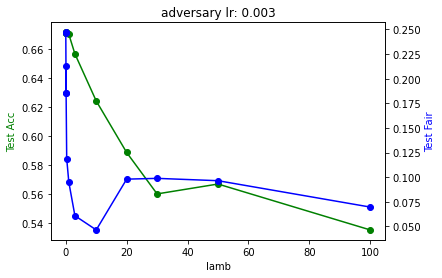

In [36]:

import matplotlib.pyplot as plt

lr_idx = 1

x = lamb_arr
y1 = results_acc[lr_idx, :]
y2 = results_fair[lr_idx, :]

print(y1, y2)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'go-')
ax2.plot(x, y2, 'bo-')

ax1.set_xlabel('lamb')
ax1.set_ylabel('Test Acc', color='g')
ax2.set_ylabel('Test Fair', color='b')

plt.title(f"adversary lr: {eta_arr[lr_idx]}")

plt.show()


